In [177]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
import io
import datetime
import matplotlib.lines as mlines
from fredapi import Fred
import statsmodels.formula.api as smf
import datetime
import pandas as pd

In [178]:
# load the data
interest = pd.read_csv("final_project_data.csv", parse_dates = True, index_col = 0)
interest

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK
1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115
1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825
1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573
1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005
1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330
...,...,...,...,...,...,...,...
2022-07-01,2.50,1.8400,0.089330,0.081688,3.6,3.6,1.2183
2022-08-01,2.76,2.2300,0.084132,0.087971,3.5,3.5,1.1647
2022-09-01,3.21,2.9100,0.082274,0.086530,3.7,3.6,1.1134
2022-10-01,3.85,3.3900,0.082149,0.088078,3.5,3.7,1.1515


In [179]:
# we will utilze the interest rate diff method;

# Implement min max scaling in a function
def scale(x):
    return (x-x.min())/(x.max()-x.min())

# Apply Scaling
interest["ir_diff"] = scale(interest["United States Interest"]) - scale(interest["United Kingdom Interest"])
interest.dropna(inplace= True)

<AxesSubplot:title={'center':'Interest Rate Differential With Scaling'}>

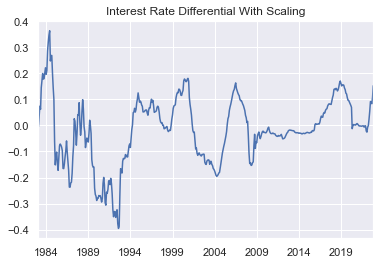

In [180]:
plt.title("Interest Rate Differential With Scaling")
interest["ir_diff"].plot()

In [181]:
interest["returns"] = np.log(interest["DEXUSUK"]).diff()
interest

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK,ir_diff,returns
1983-02-01,8.54,11.3338,0.037076,0.049259,10.4,10.7,1.5115,-0.004242,NaN
1983-03-01,8.69,10.9757,0.034847,0.053428,10.4,10.8,1.4825,0.032309,-0.019373
1983-04-01,8.63,10.2616,0.035903,0.046267,10.3,10.8,1.5573,0.073886,0.049224
1983-05-01,8.49,10.2593,0.040000,0.040038,10.2,11.0,1.6005,0.061831,0.027363
1983-06-01,9.20,9.9384,0.034411,0.036957,10.1,10.9,1.5330,0.144766,-0.043089
...,...,...,...,...,...,...,...,...,...
2022-07-01,2.50,1.8400,0.089330,0.081688,3.6,3.6,1.2183,0.091471,0.001725
2022-08-01,2.76,2.2300,0.084132,0.087971,3.5,3.5,1.1647,0.088575,-0.044993
2022-09-01,3.21,2.9100,0.082274,0.086530,3.7,3.6,1.1134,0.083235,-0.045045
2022-10-01,3.85,3.3900,0.082149,0.088078,3.5,3.7,1.1515,0.107569,0.033647


In [182]:
# Calculate the index of the row that corresponds to 80% of the data
n_rows = len(interest)
n_train = int(n_rows * 0.8)

# Use the first 80% of the data for training
train_data = interest[:n_train]
test_data = interest[n_train:]

In [183]:
#optimizing hyperparameters:

# specify candidate values for hyperparameters
ks = np.linspace(.01, .99, 10)
zs = np.linspace(.01, 3, 10)
ws = np.arange(5, 30, 5)
hs = np.array([1, 3, 6, 9, 12]) # choosing 1, 3, 6, 9, 12, 24 months to be tested. 

import itertools as it
# build a grid with all possible hyperparameters
grid = np.array(np.meshgrid(ks,zs, ws, hs)).T.reshape(-1,4)

grid

array([[1.00000000e-02, 1.00000000e-02, 5.00000000e+00, 1.00000000e+00],
       [1.00000000e-02, 3.42222222e-01, 5.00000000e+00, 1.00000000e+00],
       [1.00000000e-02, 6.74444444e-01, 5.00000000e+00, 1.00000000e+00],
       ...,
       [9.90000000e-01, 2.33555556e+00, 2.50000000e+01, 1.20000000e+01],
       [9.90000000e-01, 2.66777778e+00, 2.50000000e+01, 1.20000000e+01],
       [9.90000000e-01, 3.00000000e+00, 2.50000000e+01, 1.20000000e+01]])

In [170]:
storage = pd.DataFrame(columns = ["k", "z", "w", "h", "profits"])
df_copy = train_data.copy()

for n in range(len(grid)):
    # Each loop we pull out the values for a new set of hyperparamters from the grid
    k,z,w,h= grid[n]
    
    # We fit a filter and CI using the next set of parameters
    df_copy["Filter"] = df_copy["ir_diff"].ewm(alpha = k, adjust = False).mean()
    df_copy["Filter Error"] = df_copy["ir_diff"] -df_copy["Filter"]
    df_copy["std"] = df_copy["Filter Error"].rolling(int(w)).std()
    df_copy["Upper"] = df_copy["Filter"] + z*df_copy["std"]
    df_copy["Lower"] = df_copy["Filter"] - z*df_copy["std"]
    df_copy["test"] = np.where(df_copy["Filter Error"].abs()>z*df_copy["std"], 1, 0)*np.sign(df_copy["Filter Error"])
    
    # create vectors where we can store information on signals and when the change is first signalled
    df_copy["test2"] = 0
    df_copy["signal"] = 0
    
    for j in df_copy.index:
        # if there is a change in the signal, we want to take a position for teh next h periods
        if (df_copy.loc[j, "test"] == 1) &  (df_copy.shift().loc[j, "test"] != 1):
            df_copy.loc[j:j+datetime.timedelta(h), "signal"] = 1
            df_copy.loc[j, "test2"] = 1
        elif (df_copy.loc[j, "test"] == -1) &  (df_copy.shift().loc[j, "test"] != -1):
            df_copy.loc[j:j+datetime.timedelta(h), "signal"] =  -1
            df_copy.loc[j, "test2"] = -1
    
    # calculate metric
    df_copy["cumulative_returns"] = np.exp((df_copy["signal"].shift()*df_copy.returns).cumsum())-1
    
    # store the results
    storage = storage.append({"k":k, "z":z, "w":w, "h":h,
                "profits":df_copy["cumulative_returns"][-1]}, ignore_index = True)
    # print so I can track progress of loop (can take a few minutes)
    print(n)

C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


0
1


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


3


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


4
5
6


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


7
8


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


9
10


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


11
12


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


13


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


14


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


15
16


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


17


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


18
19


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


20
21


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


22


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


23
24


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


25


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


26
27


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


28
29


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


30
31


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


32
33


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


34
35


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


36


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


37
38
39


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


40


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


41


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


42


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


43


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


44
45


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


46
47


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


48


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


49


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


50


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


51


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


52
53


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


54


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


55


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


56


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


57


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


58


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


59


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


60


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


61


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


62
63


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


64


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


65


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


66


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


67


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


68
69


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


70


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


71


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


72


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


73


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


74


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


75


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


76


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


77
78
79


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


80
81


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


82
83


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


84


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


85
86
87


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


88
89


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


90
91


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


92


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


93
94


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


95


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


96


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


97


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


98


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


99
100
101


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


102


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


103
104
105


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


106
107


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


108
109


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


110


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


111


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


112
113


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


114
115


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


116


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


117


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


118


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


119
120


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


121
122


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


123


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


124


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


125


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


126


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


127
128


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


129


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


130


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


131
132


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


133


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


134
135


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


136


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


137


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


138


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


139


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


140


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


141


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


142
143


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


144
145


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


146


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


147
148


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


149


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


150


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


151


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


152


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


153


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


154
155


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


156
157


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


158
159


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


160


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


161
162


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


163


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


164
165


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


166


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


167
168


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


169


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


170


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


171


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


172


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


173


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


174
175


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


176
177


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


178


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


179


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


180


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


181


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


182


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


183
184


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


185


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


186


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


187
188


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


189


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


190


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


191
192


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


193


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


194


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


195
196


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


197


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


198


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


199
200


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


201


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


202
203


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


204
205


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


206
207


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


208


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


209


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


210
211


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


212


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


213
214


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


215
216


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


217
218


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


219


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


220
221


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


222


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


223


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


224
225


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


226
227
228


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


229
230


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


231


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


232


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


233


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


234


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


235


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


236
237


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


238
239


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


240


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


241


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


242


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


243


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


244


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


245


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


246
247


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


248


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


249
250


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


251


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


252


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


253
254


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


255


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


256


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


257


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


258
259


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


260
261


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


262


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


263


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


264
265


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


266
267


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


268
269


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


270


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


271


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


272


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


273


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


274


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


275
276


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


277
278


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


279


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


280


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


281


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


282


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


283


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


284
285


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


286


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


287
288


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


289


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


290
291


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


292


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


293
294


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


295


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


296


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


297
298


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


299


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


300


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


301


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


302


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


303


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


304
305


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


306


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


307
308


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


309
310


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


311
312


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


313
314


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


315


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


316
317


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


318


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


319


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


320
321
322


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


323


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


324


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


325


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


326
327


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


328


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


329
330


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


331
332


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


333


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


334
335


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


336
337


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


338


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


339


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


340


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


341


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


342
343


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


344


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


345


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


346
347


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


348
349


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


350


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


351


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


352
353


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


354
355


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


356
357


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


358


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


359
360


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


361


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


362


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


363


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


364
365


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


366


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


367
368


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


369


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


370


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


371


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


372


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


373


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


374


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


375


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


376
377


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


378


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


379


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


380
381


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


382


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


383
384


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


385
386


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


387


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


388
389


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


390
391


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


392


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


393


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


394
395


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


396
397


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


398


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


399
400


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


401


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


402


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


403


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


404
405


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


406


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


407


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


408


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


409


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


410
411


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


412


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


413
414


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


415


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


416


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


417


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


418
419


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


420
421


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


422


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


423
424


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


425


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


426
427


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


428


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


429


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


430


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


431


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


432
433


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


434


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


435


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


436
437


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


438


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


439


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


440
441


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


442


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


443


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


444
445


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


446
447


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


448


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


449


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


450
451


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


452


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


453


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


454
455


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


456


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


457


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


458


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


459
460


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


461
462


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


463


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


464


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


465


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


466


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


467


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


468
469


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


470


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


471
472


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


473


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


474


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


475
476


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


477


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


478


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


479


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


480


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


481


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


482


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


483


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


484


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


485


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


486
487


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


488
489


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


490


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


491


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


492
493


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


494


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


495


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


496
497


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


498


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


499
500


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


501


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


502


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


503


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


504
505


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


506


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


507


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


508


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


509


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


510


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


511
512


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


513


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


514
515


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


516


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


517
518


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


519
520


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


521
522


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


523


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


524
525


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


526


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


527
528


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


529
530


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


531
532


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


533


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


534


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


535
536


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


537
538


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


539


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


540
541


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


542


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


543


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


544


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


545
546
547


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


548


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


549


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


550


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


551
552


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


553
554


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


555


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


556
557


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


558


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


559


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


560
561
562


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


563


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


564
565


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


566


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


567


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


568
569
570


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


571


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


572
573


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


574
575


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


576
577


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


578


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


579


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


580


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


581


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


582
583


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


584


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


585
586


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


587


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


588
589


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


590


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


591


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


592


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


593


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


594
595


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


596
597


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


598


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


599


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


600


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


601
602


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


603
604


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


605


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


606
607
608


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


609
610


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


611
612


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


613


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


614


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


615


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


616


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


617


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


618
619


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


620


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


621


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


622


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


623


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


624


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


625
626


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


627


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


628
629


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


630
631


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


632


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


633


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


634
635


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


636
637


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


638
639


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


640
641


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


642


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


643
644


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


645


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


646


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


647


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


648


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


649
650


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


651


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


652
653
654


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


655
656


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


657
658


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


659


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


660
661


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


662


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


663


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


664


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


665


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


666
667


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


668


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


669


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


670


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


671


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


672


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


673


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


674


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


675


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


676
677


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


678
679


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


680


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


681


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


682


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


683


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


684
685
686


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


687


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


688
689


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


690


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


691


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


692
693


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


694


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


695
696


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


697


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


698
699
700


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


701


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


702
703


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


704


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


705


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


706


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


707
708


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


709
710


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


711


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


712
713


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


714


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


715
716


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


717


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


718
719


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


720
721
722


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


723


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


724
725


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


726


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


727
728
729


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


730
731


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


732


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


733
734


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


735


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


736
737
738


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


739


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


740


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


741


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


742


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


743


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


744


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


745


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


746
747


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


748
749
750


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


751


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


752


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


753


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


754


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


755
756
757


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


758
759


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


760


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


761
762


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


763


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


764


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


765
766


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


767
768


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


769
770
771


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


772


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


773


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


774


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


775
776


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


777
778
779


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


780


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


781
782


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


783


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


784


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


785


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


786


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


787
788


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


789


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


790
791


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


792


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


793


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


794


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


795


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


796


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


797
798


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


799
800


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


801
802


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


803
804


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


805


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


806
807


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


808
809


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


810


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


811
812


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


813
814


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


815


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


816


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


817


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


818
819


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


820
821


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


822
823


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


824


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


825
826


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


827
828
829


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


830


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


831


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


832


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


833


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


834


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


835
836


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


837


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


838
839
840


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


841


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


842
843


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


844
845


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


846
847


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


848


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


849
850


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


851
852


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


853
854


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


855
856


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


857
858
859


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


860


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


861
862


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


863
864


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


865
866


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


867
868


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


869


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


870
871
872


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


873
874


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


875


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


876
877


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


878
879


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


880


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


881
882


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


883


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


884
885


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


886


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


887
888


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


889
890


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


891
892


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


893
894


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


895


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


896
897


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


898
899


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


900
901


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


902


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


903


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


904
905


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


906
907


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


908


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


909


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


910


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


911
912
913


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


914


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


915
916


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


917
918
919


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


920


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


921
922


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


923


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


924
925
926


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


927


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


928
929


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


930
931


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


932


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


933
934


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


935


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


936


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


937


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


938
939


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


940


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


941


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


942
943


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


944
945


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


946


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


947


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


948


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


949


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


950


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


951


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


952


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


953


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


954


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


955
956


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


957
958


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


959
960


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


961
962


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


963
964


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


965
966


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


967
968


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


969


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


970


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


971


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


972


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


973
974


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


975
976


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


977
978


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


979
980


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


981
982


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


983


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


984
985


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


986


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


987
988


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


989


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


990


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


991


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


992


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


993


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


994
995


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


996
997


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


998
999


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1000


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1001
1002


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1003


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1004
1005


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1006
1007


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1008
1009


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1010


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1011
1012


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1013


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1014
1015


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1016
1017


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1018


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1019
1020


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1021


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1022


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1023
1024


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1025
1026


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1027


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1028
1029


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1030
1031
1032


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1033


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1034
1035


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1036


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1037
1038
1039


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1040
1041


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1042


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1043


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1044
1045


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1046


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1047
1048


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1049


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1050
1051


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1052


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1053
1054


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1055


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1056


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1057


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1058


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1059
1060


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1061


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1062
1063


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1064


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1065


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1066


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1067


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1068
1069


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1070


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1071


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1072


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1073


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1074


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1075
1076


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1077


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1078
1079


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1080


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1081


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1082


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1083
1084


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1085


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1086
1087


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1088


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1089
1090


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1091


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1092


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1093
1094
1095


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1096


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1097


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1098
1099


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1100
1101


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1102
1103


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1104
1105


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1106
1107


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1108


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1109
1110


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1111
1112


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1113
1114


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1115


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1116
1117


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1118
1119


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1120


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1121
1122
1123


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1124
1125


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1126


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1127
1128


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1129
1130


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1131
1132


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1133


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1134


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1135
1136


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1137
1138


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1139


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1140
1141


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1142


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1143


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1144
1145


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1146
1147


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1148
1149


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1150
1151


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1152


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1153


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1154


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1155
1156


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1157


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1158
1159


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1160
1161


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1162


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1163
1164


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1165
1166


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1167


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1168
1169


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1170
1171


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1172


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1173


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1174


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1175


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1176
1177


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1178
1179


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1180


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1181
1182


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1183
1184


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1185


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1186


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1187


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1188


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1189


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1190


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1191


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1192
1193


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1194
1195


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1196


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1197
1198


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1199


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1200
1201


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1202
1203


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1204


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1205


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1206
1207


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1208


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1209
1210


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1211


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1212
1213


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1214


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1215


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1216
1217


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1218


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1219


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1220
1221


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1222


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1223


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1224


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1225
1226


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1227


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1228
1229


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1230


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1231


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1232


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1233
1234


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1235


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1236


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1237
1238


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1239


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1240


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1241


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1242


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1243
1244


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1245
1246


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1247
1248


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1249


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1250
1251


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1252


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1253


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1254
1255


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1256


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1257


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1258
1259


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1260
1261


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1262
1263


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1264


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1265
1266


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1267


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1268


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1269
1270


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1271


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1272


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1273
1274


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1275


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1276
1277


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1278
1279


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1280


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1281
1282


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1283


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1284
1285


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1286


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1287
1288


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1289


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1290
1291


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1292
1293


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1294
1295


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1296
1297


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1298
1299


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1300
1301


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1302
1303


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1304


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1305


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1306
1307


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1308


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1309
1310


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1311
1312


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1313


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1314
1315


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1316
1317


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1318
1319


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1320


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1321
1322
1323


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1324


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1325


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1326


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1327


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1328
1329


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1330


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1331
1332


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1333


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1334


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1335


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1336
1337


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1338
1339


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1340
1341


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1342


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1343
1344


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1345
1346


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1347


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1348
1349


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1350
1351


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1352
1353


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1354
1355


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1356
1357


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1358
1359


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1360
1361


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1362
1363


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1364
1365


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1366


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1367


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1368
1369


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1370
1371


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1372
1373


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1374


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1375


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1376


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1377
1378


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1379
1380


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1381


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1382


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1383


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1384
1385


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1386
1387


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1388
1389


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1390


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1391


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1392


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1393
1394


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1395
1396


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1397


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1398
1399


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1400
1401


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1402
1403


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1404


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1405
1406


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1407


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1408


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1409
1410


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1411


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1412
1413


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1414
1415


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1416
1417


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1418
1419


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1420
1421


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1422


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1423


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1424
1425


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1426
1427


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1428


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1429
1430


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1431


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1432
1433


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1434


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1435
1436


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1437
1438
1439


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1440


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1441
1442


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1443
1444


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1445


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1446


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1447


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1448


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1449
1450


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1451


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1452
1453


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1454


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1455


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1456
1457


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1458
1459


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1460
1461


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1462
1463


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1464
1465


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1466
1467


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1468
1469


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1470
1471


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1472
1473


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1474
1475


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1476
1477
1478


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1479
1480


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1481


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1482
1483


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1484


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1485
1486


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1487
1488


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1489
1490


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1491


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1492


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1493
1494


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1495


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1496
1497


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1498


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1499
1500


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1501
1502


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1503


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1504
1505


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1506
1507


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1508
1509


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1510


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1511
1512


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1513


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1514
1515


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1516


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1517
1518


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1519
1520


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1521
1522


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1523


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1524
1525


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1526
1527


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1528


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1529
1530


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1531
1532


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1533
1534


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1535
1536


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1537
1538


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1539
1540


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1541


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1542
1543


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1544
1545


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1546
1547


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1548


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1549
1550


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1551
1552


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1553


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1554
1555


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1556
1557


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1558
1559


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1560


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1561
1562


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1563
1564


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1565
1566
1567


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1568


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1569
1570


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1571


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1572
1573


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1574
1575


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1576
1577


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1578


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1579
1580


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1581
1582
1583


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1584


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1585
1586
1587


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1588
1589


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1590


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1591
1592


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1593


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1594


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1595
1596


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1597
1598


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1599
1600


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1601


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1602
1603


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1604
1605


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1606
1607
1608


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1609


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1610
1611


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1612
1613


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1614


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1615
1616


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1617
1618


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1619
1620


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1621
1622


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1623
1624


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1625


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1626
1627


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1628
1629


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1630
1631


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1632


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1633
1634


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1635
1636


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1637
1638


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1639
1640


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1641
1642
1643


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1644


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1645
1646


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1647
1648


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1649
1650


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1651
1652


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1653


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1654
1655


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1656


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1657
1658


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1659


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1660


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1661
1662


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1663


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1664


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1665


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1666


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1667


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1668


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1669


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1670


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1671


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1672


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1673


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1674


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1675


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1676


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1677
1678


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1679
1680


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1681


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1682


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1683


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1684


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1685
1686


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1687
1688


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1689
1690


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1691
1692


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1693
1694


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1695
1696


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1697
1698


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1699


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1700


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1701


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1702
1703


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1704
1705


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1706
1707


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1708


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1709
1710


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1711
1712


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1713
1714


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1715


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1716
1717


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1718
1719


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1720


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1721
1722


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1723
1724


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1725
1726
1727


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1728


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1729


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1730
1731


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1732


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1733
1734


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1735
1736


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1737
1738


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1739
1740


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1741


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1742
1743


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1744


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1745
1746


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1747
1748


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1749
1750


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1751
1752


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1753
1754


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1755


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1756


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1757


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1758
1759


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1760


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1761


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1762
1763


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1764


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1765
1766


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1767
1768


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1769
1770


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1771
1772


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1773
1774


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1775
1776


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1777
1778


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1779
1780


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1781


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1782
1783


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1784


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1785


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1786
1787


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1788
1789


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1790


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1791


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1792


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1793
1794


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1795
1796


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1797


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1798
1799


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1800
1801


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1802
1803


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1804
1805
1806


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1807


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1808
1809
1810


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1811


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1812
1813


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1814
1815


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1816


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1817
1818


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1819


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1820


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1821


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1822
1823


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1824


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1825


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1826


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1827
1828


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1829
1830


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1831
1832


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1833


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1834
1835


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1836
1837


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1838


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1839


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1840


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1841


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1842
1843


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1844


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1845


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1846


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1847
1848


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1849
1850


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1851
1852


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1853


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1854
1855


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1856


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1857
1858


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1859


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1860


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1861


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1862


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1863


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1864


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1865
1866


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1867


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1868
1869


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1870
1871


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1872
1873


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1874


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1875


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1876
1877


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1878


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1879
1880


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1881


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1882


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1883


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1884


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1885
1886


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1887
1888


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1889


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1890


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1891


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1892


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1893


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1894
1895


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1896


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1897
1898


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1899
1900


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1901


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1902
1903


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1904
1905


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1906
1907


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1908
1909


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1910


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1911
1912


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1913


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1914
1915


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1916
1917


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1918


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1919


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1920


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1921


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1922


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1923
1924


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1925
1926
1927


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1928


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1929


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1930


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1931


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1932


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1933
1934


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1935


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1936
1937


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1938
1939


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1940
1941
1942


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1943


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1944


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1945


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1946
1947


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1948
1949


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1950
1951


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1952


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1953
1954


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1955


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1956
1957


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1958


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1959
1960


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1961


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1962


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1963


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1964


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1965
1966
1967


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1968


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1969


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1970
1971


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1972


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1973
1974


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1975


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1976
1977


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1978


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1979
1980


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1981
1982


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1983
1984


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1985


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1986
1987


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1988
1989


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1990


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1991
1992


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1993
1994


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1995


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1996


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1997
1998


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


1999
2000


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2001
2002


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2003


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2004


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2005
2006


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2007
2008


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2009


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2010
2011


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2012
2013


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2014


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2015


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2016
2017


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2018


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2019


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2020
2021


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2022
2023


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2024
2025


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2026
2027


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2028


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2029
2030


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2031


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2032


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2033
2034
2035


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2036


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2037
2038


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2039
2040


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2041
2042


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2043


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2044
2045


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2046


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2047
2048


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2049


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2050
2051


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2052


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2053
2054


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2055


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2056
2057


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2058
2059


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2060


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2061


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2062
2063


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2064


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2065


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2066


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2067


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2068


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2069


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2070
2071


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2072


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2073
2074


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2075
2076


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2077
2078


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2079


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2080
2081


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2082


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2083
2084


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2085
2086
2087


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2088


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2089


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2090


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2091


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2092


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2093


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2094
2095


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2096


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2097


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2098
2099


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2100


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2101
2102


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2103
2104


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2105
2106


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2107
2108


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2109
2110


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2111
2112


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2113
2114


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2115
2116
2117


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2118


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2119
2120


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2121
2122


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2123


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2124
2125


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2126


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2127
2128


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2129
2130


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2131
2132


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2133
2134


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2135


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2136
2137


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2138
2139


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2140
2141


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2142
2143


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2144
2145


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2146
2147


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2148


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2149
2150


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2151
2152


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2153


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2154
2155


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2156
2157
2158


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2159


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2160
2161


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2162


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2163


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2164
2165


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2166
2167


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2168


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2169
2170
2171


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2172


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2173


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2174
2175


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2176
2177


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2178


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2179
2180
2181


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2182


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2183


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2184


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2185


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2186


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2187
2188


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2189
2190


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2191


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2192


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2193


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2194
2195


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2196
2197


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2198
2199


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2200
2201


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2202


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2203
2204
2205


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2206


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2207
2208


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2209


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2210
2211


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2212
2213


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2214


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2215
2216


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2217


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2218
2219


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2220
2221


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2222
2223


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2224
2225
2226


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2227


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2228
2229


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2230
2231


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2232
2233


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2234
2235


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2236
2237


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2238
2239


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2240
2241


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2242
2243


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2244


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2245
2246


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2247
2248


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2249
2250


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2251
2252


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2253


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2254
2255


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2256
2257


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2258
2259


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2260
2261


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2262
2263


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2264
2265


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2266
2267


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2268
2269


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2270
2271


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2272


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2273
2274


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2275
2276


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2277
2278


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2279
2280


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2281
2282
2283


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2284


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2285
2286


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2287
2288


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2289
2290


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2291
2292


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2293


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2294


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2295


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2296
2297


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2298


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2299


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2300
2301


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2302


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2303
2304


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2305
2306


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2307


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2308


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2309
2310


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2311


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2312


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2313


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2314
2315
2316


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2317


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2318


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2319


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2320


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2321


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2322
2323


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2324


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2325
2326


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2327
2328


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2329


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2330


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2331
2332


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2333


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2334
2335


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2336
2337


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2338
2339


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2340
2341


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2342
2343


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2344


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2345
2346


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2347
2348


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2349
2350


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2351


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2352


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2353
2354


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2355
2356


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2357


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2358
2359


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2360


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2361
2362


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2363


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2364
2365


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2366
2367


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2368
2369


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2370


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2371


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2372
2373
2374


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2375


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2376
2377


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2378
2379
2380


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2381


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2382
2383


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2384
2385


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2386
2387
2388


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2389


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2390
2391


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2392


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2393


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2394
2395


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2396
2397
2398


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2399


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2400
2401


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2402


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2403
2404


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2405


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2406
2407


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2408


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2409
2410
2411


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2412


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2413
2414


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2415


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2416
2417


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2418
2419


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2420
2421


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2422


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2423
2424


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2425
2426


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2427
2428


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2429
2430


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2431
2432


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2433
2434


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2435
2436


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2437
2438


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2439


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2440


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2441
2442


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2443


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2444
2445


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2446
2447


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2448
2449
2450


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2451


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2452


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2453


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2454


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2455
2456


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2457
2458


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2459
2460


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2461
2462


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2463


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2464


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2465
2466


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2467


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2468
2469


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2470
2471
2472


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2473


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2474


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2475
2476


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2477


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2478
2479


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2480


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2481


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2482


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2483


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2484
2485


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2486
2487


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2488
2489


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2490


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2491
2492


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2493
2494


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2495


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,
C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


2496
2497
2498
2499


C:\Users\saad_\AppData\Local\Temp\ipykernel_35484\2682242171.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  storage = storage.append({"k":k, "z":z, "w":w, "h":h,


In [277]:
storage = storage.sort_values(by = "profits").reset_index(drop = True)
storage

,k,z,w,h,profits
0,0.881111,0.342222,25.0,3.0,-0.500501
1,0.881111,0.342222,25.0,1.0,-0.500501
2,0.881111,0.342222,25.0,6.0,-0.500501
3,0.881111,0.342222,25.0,12.0,-0.500501
4,0.881111,0.342222,25.0,9.0,-0.500501
...,...,...,...,...,...
2495,0.118889,1.338889,5.0,9.0,0.227282
2496,0.118889,1.338889,5.0,1.0,0.227282
2497,0.118889,1.338889,5.0,6.0,0.227282
2498,0.118889,1.338889,5.0,12.0,0.227282


In [172]:
def heatmap(x, y, metric, values):
    
    # specify the columns I will be pulling from the results
    p2p = values[[x, y, metric]]
    
    # If p > 2, we need to group 
    heat = np.round(p2p.groupby([x,y]).max(),1)
    heat = heat.unstack()[metric]

    # round labels
    heat.index = np.round(heat.index,2)
    heat.columns = np.round(heat.columns,2)

    # make plot
    f, ax = plt.subplots(figsize=(25, 12))
    ax = sns.heatmap(heat, fmt='.1g')
    ax.set_title("Heat map of "+ metric,size = 18)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel(y, size = 18)
    ax.set_ylabel(x, size = 18)
    ax.collections[0].colorbar.set_label(metric, size = 18)
    sns.set(font_scale=1)
    plt.show()

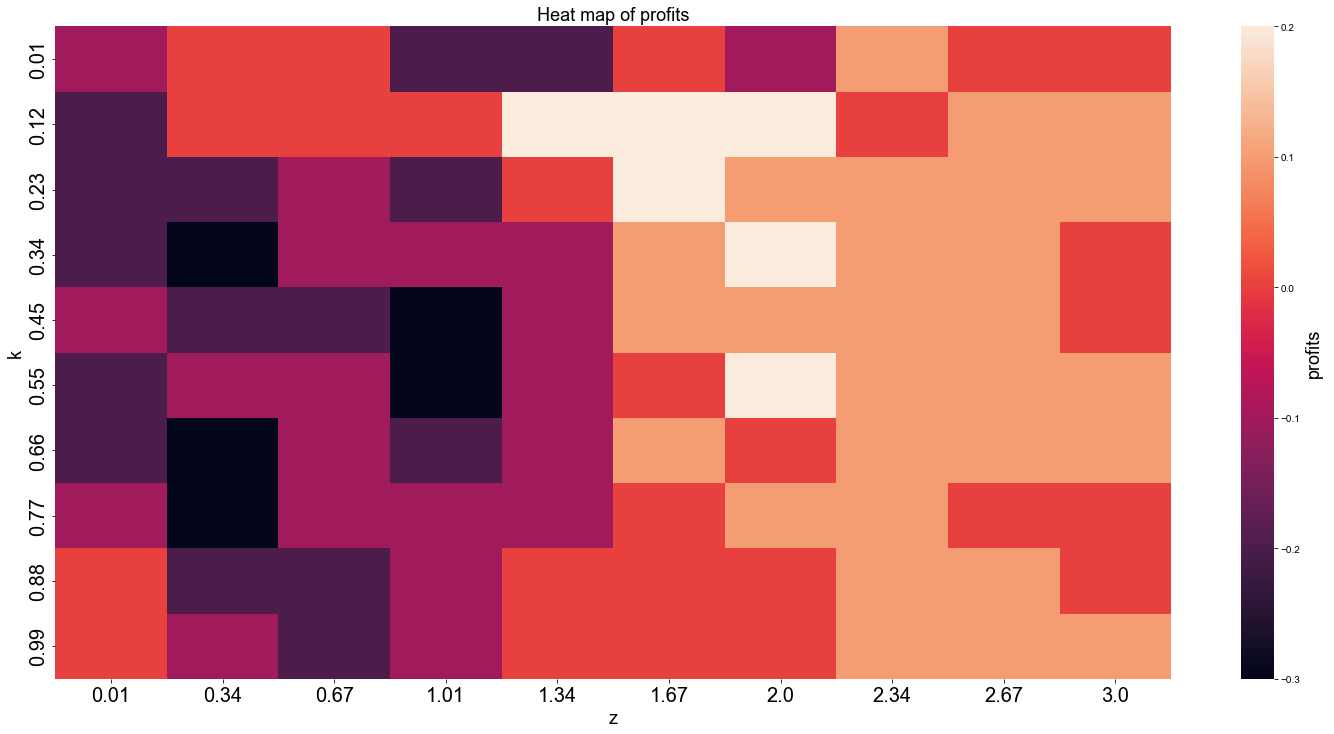

In [173]:
import seaborn as sns

heatmap("k", "z","profits", storage)

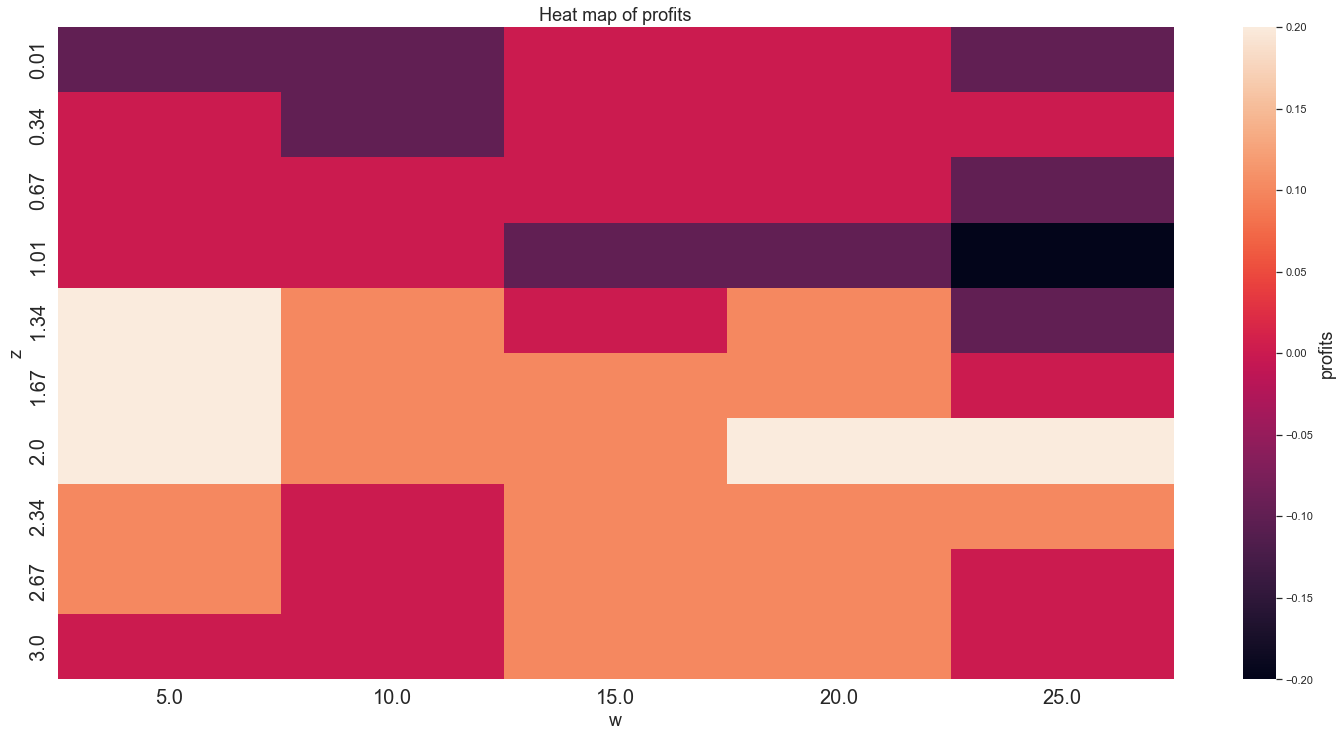

In [280]:
heatmap("z", "w","profits", storage)

Text(0.5, 1.0, 'k optimization')

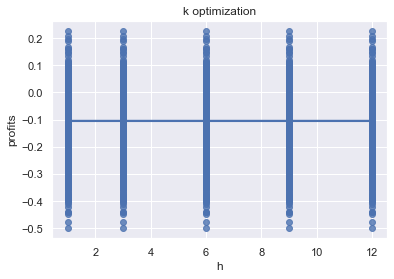

In [281]:
#Visualizing profits and different values of the holding period
sns.regplot(data = storage, x = "h", y = "profits", lowess = True)
plt.title("k optimization")

It can be seen that the value of h does not affect the profits, thus, we will choose h = 1

In [184]:
k,z,w, h, p = storage.iloc[-1]
print("k: ",k, "z: ",z, "w: ",w, "h: ",h, "p: ",p)

k:  0.99 z:  3.0 w:  25.0 h:  12.0 p:  0.014051494875190862


In [185]:
# The choosen parameters:
df_copy = train_data.copy()
k = 0.118
w = 5
z = 1.338
h = 1

In [186]:
# This implements the kalman filter in python
# It is simple otherwise to create using a for loop
df_copy["Filter"] = df_copy.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
df_copy["Filter Error"] = df_copy.ir_diff - df_copy["Filter"]

# compute the rolling standard deviation
df_copy["std"] = df_copy["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
df_copy["Upper"] = df_copy["Filter"] + z*df_copy["std"]
df_copy["Lower"] = df_copy["Filter"] - z*df_copy["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
df_copy["test"] = np.where(df_copy["Filter Error"].abs()>z*df_copy["std"], -1, 0)*np.sign(df_copy["Filter Error"])

In [187]:
# We let the holding period (i) be 1 month
i = 1

# create a new column that we will populate with our monthely position
df_copy.loc[:, str(i)+"_signal"] = 0

# loop through each day in the dataset
for j in df_copy.index:
    # If our monthly signal is not 0
    if df_copy.loc[j, "test"] != 0:
        # Make the next i days equal to the monthly signal
        df_copy.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = df_copy.loc[j, "test"]

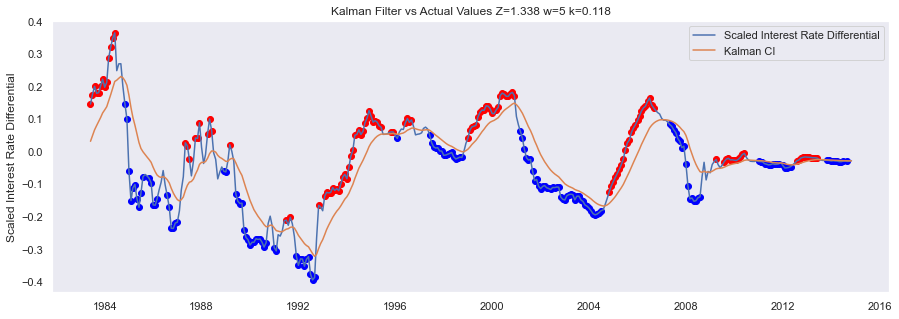

In [188]:
data2 = df_copy.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["ir_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
#ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["ir_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["ir_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

In [189]:
# calculate the cumulative returns for the current strategy
i = 1
df_copy[str(i)+"_returns"] = np.exp((df_copy[str(i)+"_signal"].shift()*df_copy.returns).cumsum())-1
# calculate whether each signal was a success by finding the difference between the returns
# at the switching points. If the difference is positive, that means the signal made money
s = 1
df_copy[str(s)+"_success"] = ((df_copy[df_copy.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

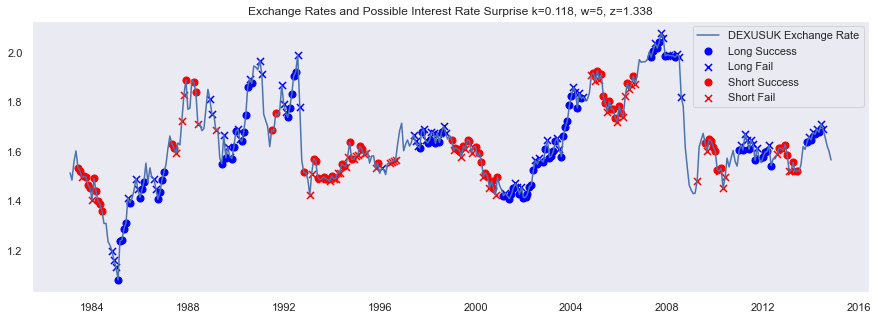

In [190]:
# Visulaize the training data stratigy
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(df_copy["DEXUSUK"])

longsuccess = df_copy[(df_copy[str(s)+"_success"] == 1) & (df_copy["test"] == 1)]
longfail = df_copy[(df_copy[str(s)+"_success"] == 0) & (df_copy["test"] == 1)] 
shortsuccess = df_copy[(df_copy[str(s)+"_success"] == 1) & (df_copy["test"] == -1)]
shortfail = df_copy[(df_copy[str(s)+"_success"] == 0) & (df_copy["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["DEXUSUK"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["DEXUSUK"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["DEXUSUK"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["DEXUSUK"], color = 'red', s = 50, marker = "x")

plt.legend(["DEXUSUK Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

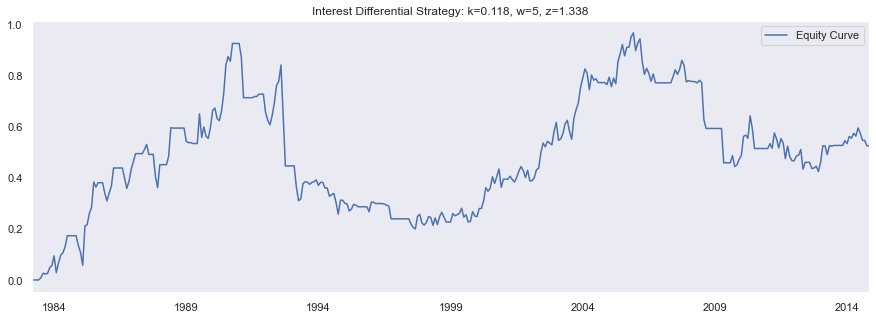

In [191]:
plt.figure(figsize = (15, 5))
d2 = df_copy[df_copy.index.year >= 2020]
(df_copy["1_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

In [192]:
# The choosen parameters:
test_df_copy = test_data.copy()
k = 0.118
w = 5
z = 1.338
h = 1

In [193]:
# This implements the kalman filter in python
# It is simple otherwise to create using a for loop
test_df_copy["Filter"] = test_df_copy.ir_diff.ewm(alpha = k, adjust = False).mean()

# Compute the filter error
test_df_copy["Filter Error"] = test_df_copy.ir_diff - test_df_copy["Filter"]

# compute the rolling standard deviation
test_df_copy["std"] = test_df_copy["Filter Error"].rolling(w).std()

# create our confidence intervals or "boundaries of inaction"
# these are scaled by teh number of standard deviations "z"
test_df_copy["Upper"] = test_df_copy["Filter"] + z*test_df_copy["std"]
test_df_copy["Lower"] = test_df_copy["Filter"] - z*test_df_copy["std"]

# Create signal that evaluates whether we are outside the threshold
# then multiply by the direction of the mistake
# (we use economic theory to decide which direction is long or short)
test_df_copy["test"] = np.where(test_df_copy["Filter Error"].abs()>z*test_df_copy["std"], -1, 0)*np.sign(test_df_copy["Filter Error"])

In [197]:
# We let the holding period (i) be 41 days
i = 1

# create a new column that we will populate with our daily position
test_df_copy.loc[:, str(i)+"_signal"] = 0

# loop through each day in the dataset
for j in test_df_copy.index:
    # If our monthly signal is not 0
    if test_df_copy.loc[j, "test"] != 0:
        # Make the next i days equal to the monthly signal
        test_df_copy.loc[j:j+datetime.timedelta(i), str(i)+"_signal"] = test_df_copy.loc[j, "test"]

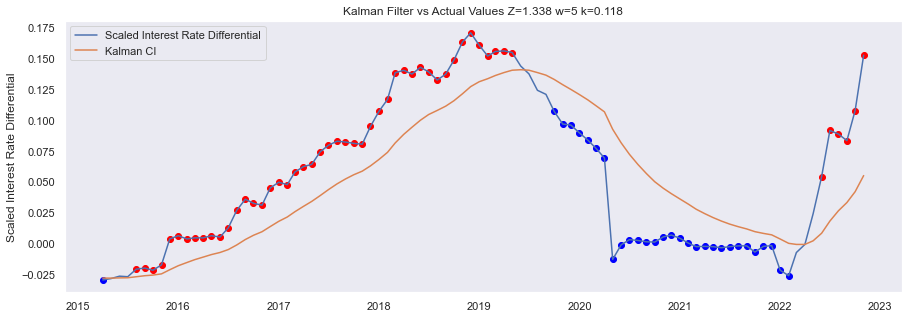

In [198]:
data2 = test_df_copy.dropna()
fig, ax = plt.subplots(figsize = (15, 5))
ax.set_title("Kalman Filter vs Actual Values " + "Z="+str(z) + " w=" + str(w)+ " k=" + str(k))

ax.set_ylabel("Scaled Interest Rate Differential")

# Plot the actual series and the filter
ax.plot(data2["ir_diff"])
ax.plot(data2["Filter"])

# This code block is used to add confidence intervals when z > 0
#ax.fill_between(data2.index, data2.Lower, data2.Upper, color='b', alpha=.2)

# add scatterplots using boolean indexing
# We change the colors and shapes based on the conditions
ax.scatter(data2[data2.test == 1].index, data2[data2.test == 1]["ir_diff"], color = "blue")
ax.scatter(data2[data2.test == -1].index, data2[data2.test == -1]["ir_diff"], color = "red")
ax.legend(["Scaled Interest Rate Differential", "Kalman CI"])

# this code can let us zoom in on certain time periods
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
ax.grid()

In [199]:
# calculate the cumulative returns for the current strategy
i = 1
test_df_copy[str(i)+"_returns"] = np.exp((test_df_copy[str(i)+"_signal"].shift()*test_df_copy.returns).cumsum())-1
# calculate whether each signal was a success by finding the difference between the returns
# at the switching points. If the difference is positive, that means the signal made money
s = 1
test_df_copy[str(s)+"_success"] = ((test_df_copy[test_df_copy.test!= 0][str(s)+"_returns"].diff()>0)*1).shift(-1)

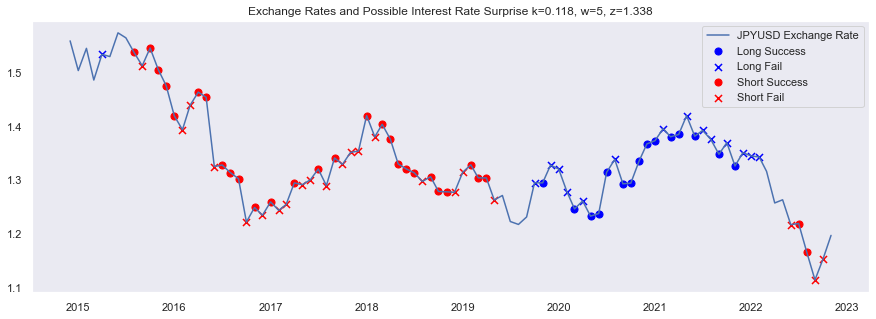

In [200]:
# Visulaize the training data stratigy
plt.figure(figsize = (15, 5))

plt.title("Exchange Rates and Possible Interest Rate Surprise"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))

plt.plot(test_df_copy["DEXUSUK"])

longsuccess = test_df_copy[(test_df_copy[str(s)+"_success"] == 1) & (test_df_copy["test"] == 1)]
longfail = test_df_copy[(test_df_copy[str(s)+"_success"] == 0) & (test_df_copy["test"] == 1)] 
shortsuccess = test_df_copy[(test_df_copy[str(s)+"_success"] == 1) & (test_df_copy["test"] == -1)]
shortfail = test_df_copy[(test_df_copy[str(s)+"_success"] == 0) & (test_df_copy["test"] == -1)]

plt.scatter(longsuccess.index, longsuccess["DEXUSUK"], color = 'blue', s = 50)
plt.scatter(longfail.index, longfail["DEXUSUK"], color = 'blue', s = 50, marker = "x")

plt.scatter(shortsuccess.index, shortsuccess["DEXUSUK"], color = 'red', s = 50)
plt.scatter(shortfail.index, shortfail["DEXUSUK"], color = 'red', s = 50, marker = "x")

plt.legend(["JPYUSD Exchange Rate", "Long Success", "Long Fail", "Short Success", "Short Fail"])
#plt.xlim([datetime.date(2022, 1, 1), datetime.date(2023, 1, 1)])
plt.grid()

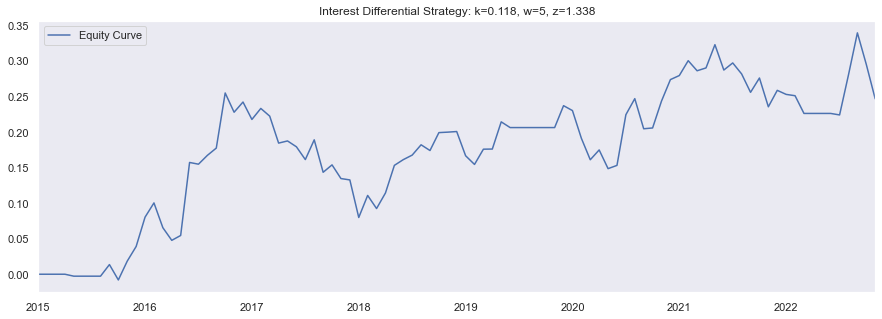

In [201]:
plt.figure(figsize = (15, 5))
d2 = test_df_copy[test_df_copy.index.year >= 2020]
(test_df_copy["1_returns"].dropna()).plot()

plt.title("Interest Differential Strategy:"+ " k=" + str(k)+", w="+str(w)+", z="+str(z))
plt.legend(["Equity Curve", "Long Success", "Long Fail", "Short Success", "Short Fail"])

plt.grid()
#plt.xlim(["1/1/2019", "1/1/2022"])

In [291]:

test_df_copy["success"] = test_df_copy["1_success"]
test_df_copy["signal"] = test_df_copy["1_signal"]
test_df_copy["strat_returns"] = test_df_copy["signal"].shift()*test_df_copy.returns
test_df_copy["cumulative_returns"] = np.exp((test_df_copy["signal"].shift()*test_df_copy.returns).cumsum())-1
test_df_copy

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK,ir_diff,returns,Filter,...,1_success,cumulative_returns,success,signal,strat_returns,rf,risk_monthly,profit_excess,Profits_pct_change,market_excess
2014-12-01 00:00:00-05:00,0.15,0.53,0.012315,0.011134,5.8,5.6,1.5578,-0.027543,-0.003844,-0.027543,...,NaN,NaN,NaN,0,NaN,0.214545,0.000179,NaN,NaN,NaN
2015-01-01 00:00:00-05:00,0.16,0.53,0.006531,0.007056,5.6,5.5,1.5026,-0.026671,-0.036078,-0.027440,...,NaN,0.000000,NaN,0,-0.000000,0.195500,0.000163,-0.000163,NaN,NaN
2015-02-01 00:00:00-05:00,0.15,0.53,-0.002299,0.005066,5.7,5.4,1.5439,-0.027543,0.027115,-0.027452,...,NaN,0.000000,NaN,0,0.000000,0.224211,0.000187,-0.000187,NaN,NaN
2015-03-01 00:00:00-05:00,0.14,0.53,-0.000870,0.004036,5.5,5.4,1.4850,-0.028415,-0.038897,-0.027566,...,NaN,0.000000,NaN,0,-0.000000,0.253636,0.000211,-0.000211,NaN,NaN
2015-04-01 00:00:00-04:00,0.13,0.53,-0.000220,0.003021,5.5,5.4,1.5328,-0.029287,0.031681,-0.027769,...,0.0,0.000000,0.0,1,0.000000,0.233636,0.000194,-0.000194,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01 00:00:00-04:00,2.50,1.84,0.089330,0.081688,3.6,3.6,1.2183,0.091471,0.001725,0.018252,...,1.0,0.223730,1.0,-1,-0.001725,3.019500,0.002482,-0.004207,inf,inf
2022-08-01 00:00:00-04:00,2.76,2.23,0.084132,0.087971,3.5,3.5,1.1647,0.088575,-0.044993,0.026550,...,1.0,0.280047,1.0,-1,0.044993,3.275217,0.002689,0.042304,-27.079807,-27.082497
2022-09-01 00:00:00-04:00,3.21,2.91,0.082274,0.086530,3.7,3.6,1.1134,0.083235,-0.045045,0.033239,...,0.0,0.339025,0.0,-1,0.045045,3.891905,0.003187,0.041858,0.001161,-0.002026
2022-10-01 00:00:00-04:00,3.85,3.39,0.082149,0.088078,3.5,3.7,1.1515,0.107569,0.033647,0.042010,...,0.0,0.294721,0.0,-1,-0.033647,4.427500,0.003617,-0.037264,-1.746963,-1.750579


In [203]:
# Binomial test:
df = test_df_copy[test_df_copy.test != 0][["1_signal", "DEXUSUK"]].copy()
df['D'] = df["1_signal"]

In [204]:
df['s_current'] = test_df_copy[test_df_copy.index.isin(df.index)]["DEXUSUK"].values
df['s_future'] = df['DEXUSUK'].shift(1)


# Get the realized exchange rate
df['R'] = np.where(df['s_future'] >= df['s_current'], 1, -1)

In [205]:
## Sample Covariance
df['W'] = (df['D']-np.mean(df['D']))*(df['R']-np.mean(df['R']))
T_B = np.mean(df['W'])

In [206]:
T_B

-0.13325401546698395

In [207]:
## Newey-West LRV estimator
dy = df['W'] - np.mean(df['W'])
gamma_0 = sum((dy)**2)/len(df)
gamma_1 = np.mean((dy*dy.shift(-1))[:len(df)-1])
LRV = gamma_0 + 2*(1-1/2)*gamma_1

In [208]:
## Test-statistic
from scipy.stats import norm

statistic = T_B/np.sqrt(LRV/df.shape[0])
print('Test statistic : ', statistic, ', 5 % critical value : ', round(norm.ppf(0.95),2))

Test statistic :  -1.4121290063479914 , 5 % critical value :  1.64


Since the test statisitcs is smaller than the critical value, we do not reject the null hypothesis.

In [209]:
# Geo average monthely

# number of periods we have 
t = len(test_df_copy['DEXUSUK'])

# Calculate the geometric mean of the quarterly returns
# we will use cummulative returns as the basis 

geometric_mean = (1 + test_df_copy['cumulative_returns']).prod()**(1/len(test_df_copy['cumulative_returns'])) - 1
print("the geometric average monthely return is:", geometric_mean)

the geometric average monthely return is: 0.17066695270959698


In [282]:
# standard deviation

std = test_df_copy['cumulative_returns'].std()*100
std


8.773694408108124

In [277]:
# high Month

high_month = test_df_copy.strat_returns[1:].max()
high_month_index = test_df_copy[test_df_copy['strat_returns'] == high_month].index[0]
print("High Month:", high_month)
print("Index of High Month:", high_month_index)

High Month: 0.0928218810795372
Index of High Month: 2016-06-01 00:00:00-04:00


In [278]:
# Low Month

low_month = test_df_copy.strat_returns[1:].min()
low_month_index = test_df_copy[test_df_copy['strat_returns'] == low_month].index[0]
print("Low Month:", low_month)
print("Index of High Month:", low_month_index)

Low Month: -0.047701961550728145
Index of High Month: 2018-01-01 00:00:00-05:00


In [283]:
# Annualized return

P = 1000000

t = len(test_df_copy)/4.  # since 4 quarters in a year 
A = (test_df_copy["cumulative_returns"].iloc[-1]/100+1)*P
ann_ret = (((A/P)**(1/t))-1)*100
ann_ret

0.010252030403168355

In [284]:
# Annualized standard deviation

# calculate the anualized standard deviation
ann_std = test_df_copy['cumulative_returns'].std()*np.sqrt(4)*100
ann_std

17.547388816216248

In [242]:
# Risk free rate

rf_rate = pd.read_csv("1-year-treasury-rate-yield-chart.csv", index_col = 0, parse_dates = True).dropna()

rf_rate

,value
date,
1962-01-02,3.22
1962-01-03,3.24
1962-01-04,3.24
1962-01-05,3.26
1962-01-08,3.31
...,...
2022-12-16,4.61
2022-12-19,4.64
2022-12-20,4.64


In [243]:
# get monthely data
rf_rate_monthely = rf_rate.resample('MS').mean()
start_date = '2014-12-01'
end_date = '2022-11-1'
rf_rate_range = rf_rate_monthely.loc[start_date:end_date]
rf_rate_range

,value
date,
2014-12-01,0.214545
2015-01-01,0.195500
2015-02-01,0.224211
2015-03-01,0.253636
2015-04-01,0.233636
...,...
2022-07-01,3.019500
2022-08-01,3.275217
2022-09-01,3.891905


In [244]:
test_df_copy["rf"] = rf_rate_range
test_df_copy

,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK,ir_diff,returns,Filter,...,test,3_signal,1_signal,1_returns,1_success,cumulative_returns,success,signal,strat_returns,rf
2014-12-01,0.15,0.53,0.012315,0.011134,5.8,5.6,1.5578,-0.027543,-0.003844,-0.027543,...,0.0,0,0,NaN,NaN,NaN,NaN,0,NaN,0.214545
2015-01-01,0.16,0.53,0.006531,0.007056,5.6,5.5,1.5026,-0.026671,-0.036078,-0.027440,...,0.0,0,0,0.000000,NaN,0.000000,NaN,0,-0.000000,0.195500
2015-02-01,0.15,0.53,-0.002299,0.005066,5.7,5.4,1.5439,-0.027543,0.027115,-0.027452,...,-0.0,0,0,0.000000,NaN,0.000000,NaN,0,0.000000,0.224211
2015-03-01,0.14,0.53,-0.000870,0.004036,5.5,5.4,1.4850,-0.028415,-0.038897,-0.027566,...,-0.0,0,0,0.000000,NaN,0.000000,NaN,0,-0.000000,0.253636
2015-04-01,0.13,0.53,-0.000220,0.003021,5.5,5.4,1.5328,-0.029287,0.031681,-0.027769,...,1.0,1,1,0.000000,0.0,0.000000,0.0,1,0.000000,0.233636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,2.50,1.84,0.089330,0.081688,3.6,3.6,1.2183,0.091471,0.001725,0.018252,...,-1.0,-1,-1,0.223730,1.0,0.223730,1.0,-1,-0.001725,3.019500
2022-08-01,2.76,2.23,0.084132,0.087971,3.5,3.5,1.1647,0.088575,-0.044993,0.026550,...,-1.0,-1,-1,0.280047,1.0,0.280047,1.0,-1,0.044993,3.275217
2022-09-01,3.21,2.91,0.082274,0.086530,3.7,3.6,1.1134,0.083235,-0.045045,0.033239,...,-1.0,-1,-1,0.339025,0.0,0.339025,0.0,-1,0.045045,3.891905
2022-10-01,3.85,3.39,0.082149,0.088078,3.5,3.7,1.1515,0.107569,0.033647,0.042010,...,-1.0,-1,-1,0.294721,0.0,0.294721,0.0,-1,-0.033647,4.427500


In [286]:
# Sharp ratio

# get annualized returns and standard deviation  

excess_return = test_df_copy["cumulative_returns"]- test_df_copy["rf"]
anualized_excess = ((excess_return+1).prod()**(1/t)-1)*100
excess_ann_std = excess_return.std()*np.sqrt(4)*100
(anualized_excess)/excess_ann_std


-0.37428783094217816

In [287]:
# Number of Winning Months

wins = len(test_df_copy[test_df_copy['strat_returns'] > 0])
(wins/515)*100

8.54368932038835

In [288]:
# Max. Drawdown

(((test_df_copy.cumulative_returns) - (test_df_copy.cumulative_returns).cummax())/(test_df_copy.cumulative_returns).cummax()).min()

-inf

In [249]:
# Regression

# Download data for the S&P 500 index
spy = yf.Ticker("^GSPC")
snp = spy.history(period="max")
# Select only the closing price column
snp_close = snp[["Close"]]
snp_close.index = pd.to_datetime(snp_close.index)
snp_close
# convert closing price to returns
snp_close = snp_close.pct_change()
# get quarterly data
snp_monthely = snp_close.resample('MS').mean()
snp_monthely.dropna()

,Close
Date,
1928-01-01 00:00:00-05:00,-0.000215
1928-02-01 00:00:00-05:00,-0.000916
1928-03-01 00:00:00-05:00,0.005067
1928-04-01 00:00:00-05:00,0.001251
1928-05-01 00:00:00-04:00,0.000622
...,...
2022-11-01 00:00:00-04:00,0.002642
2022-12-01 00:00:00-05:00,-0.002830
2023-01-01 00:00:00-05:00,0.003053


In [125]:
snp_monthely.index = snp_monthely.index.tz_convert('US/Eastern')

In [250]:
snp_monthely_range = snp_monthely.loc[start_date:end_date]
snp_monthely_range

,Close
Date,
2014-12-01 00:00:00-05:00,-0.000146
2015-01-01 00:00:00-05:00,-0.001521
2015-02-01 00:00:00-05:00,0.002834
2015-03-01 00:00:00-05:00,-0.000759
2015-04-01 00:00:00-04:00,0.000418
...,...
2022-07-01 00:00:00-04:00,0.004439
2022-08-01 00:00:00-04:00,-0.001812
2022-09-01 00:00:00-04:00,-0.004550


In [251]:
test_df_copy.index = test_df_copy.index.tz_localize('US/Eastern')
snp_rf = pd.merge(snp_monthely_range, test_df_copy, left_index=True, right_index=True)
snp_rf

,Close,United States Interest,United Kingdom Interest,United States Inflation,United Kingdom Inflation,United States Unemployment,United Kingdom Unemployment,DEXUSUK,ir_diff,returns,...,1_signal,1_returns,1_success,cumulative_returns,success,signal,strat_returns,rf,risk_monthly,profit_excess
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-01 05:00:00+00:00,-0.000146,0.15,0.53,0.012315,0.011134,5.8,5.6,1.5578,-0.027543,-0.003844,...,0,NaN,NaN,NaN,NaN,0,NaN,0.214545,0.000179,NaN
2015-01-01 05:00:00+00:00,-0.001521,0.16,0.53,0.006531,0.007056,5.6,5.5,1.5026,-0.026671,-0.036078,...,0,0.000000,NaN,0.000000,NaN,0,-0.000000,0.195500,0.000163,-0.000163
2015-02-01 05:00:00+00:00,0.002834,0.15,0.53,-0.002299,0.005066,5.7,5.4,1.5439,-0.027543,0.027115,...,0,0.000000,NaN,0.000000,NaN,0,0.000000,0.224211,0.000187,-0.000187
2015-03-01 05:00:00+00:00,-0.000759,0.14,0.53,-0.000870,0.004036,5.5,5.4,1.4850,-0.028415,-0.038897,...,0,0.000000,NaN,0.000000,NaN,0,-0.000000,0.253636,0.000211,-0.000211
2015-04-01 04:00:00+00:00,0.000418,0.13,0.53,-0.000220,0.003021,5.5,5.4,1.5328,-0.029287,0.031681,...,1,0.000000,0.0,0.000000,0.0,1,0.000000,0.233636,0.000194,-0.000194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01 04:00:00+00:00,0.004439,2.50,1.84,0.089330,0.081688,3.6,3.6,1.2183,0.091471,0.001725,...,-1,0.223730,1.0,0.223730,1.0,-1,-0.001725,3.019500,0.002482,-0.004207
2022-08-01 04:00:00+00:00,-0.001812,2.76,2.23,0.084132,0.087971,3.5,3.5,1.1647,0.088575,-0.044993,...,-1,0.280047,1.0,0.280047,1.0,-1,0.044993,3.275217,0.002689,0.042304
2022-09-01 04:00:00+00:00,-0.004550,3.21,2.91,0.082274,0.086530,3.7,3.6,1.1134,0.083235,-0.045045,...,-1,0.339025,0.0,0.339025,0.0,-1,0.045045,3.891905,0.003187,0.041858


In [252]:
# calculate excess returns 

snp_rf['excess_return'] = snp_rf['cumulative_returns'] - snp_rf['rf']
snp_rf['excess_market_return'] = snp_rf['Close'] - snp_rf['rf']

In [253]:
# regression 

import statsmodels.formula.api as smf

mod = smf.ols('excess_return~excess_market_return', data = snp_rf).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.407e+04
Date:                Mon, 27 Mar 2023   Prob (F-statistic):          2.68e-103
Time:                        10:36:17   Log-Likelihood:                 98.884
No. Observations:                  95   AIC:                            -193.8
Df Residuals:                      93   BIC:                            -188.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1563      0.013     11.812      0.000       0.130       0.183
excess_market_return     0.9837      0.008    118.602      0.000       0.967       1.000
==============================================================================
Omnibus:                        4.178   Durbin-Watson:                   0.108
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                3.658
Skew:                          -0.392   Prob(JB):                        0.161
Kurtosis:                       2.443   Cond. No.                         2.98
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [289]:
# Alpha
alpha = str(mod.params[0])
alpha

'0.1563062319318541'

In [290]:
# beta
mod.params[1]


0.9837442856422389

In [ ]:
test_df_copy['risk_monthly'] = (test_df_copy['rf']*0.01+1)**(1/12)-1
test_df_copy['Profits_pct_change'] = test_df_copy["strat_returns"].pct_change()
test_df_copy['profit_excess'] = test_df_copy['strat_returns'] - test_df_copy['risk_monthly']
test_df_copy['market_excess'] = test_df_copy['Profits_pct_change']- test_df_copy['risk_monthly']

In [294]:
# Montyly R-Squared 
df5 = test_df_copy.copy()
df5 = df5[["profit_excess", "market_excess"]].dropna()
df5 = df5.replace([np.inf, -np.inf], np.nan).dropna() 
ols = smf.ols(formula = 'profit_excess ~ market_excess', data = df5).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          profit_excess   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.323
Date:                Mon, 27 Mar 2023   Prob (F-statistic):              0.132
Time:                        10:56:41   Log-Likelihood:                 179.55
No. Observations:                  79   AIC:                            -355.1
Df Residuals:                      77   BIC:                            -350.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0010      0.003      0.334      0.740      -0.005       0.007
market_excess     0.0002      0.000      1.524      0.132    -5.4e-05       0.000
==============================================================================
Omnibus:                        9.321   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.876
Skew:                           0.633   Prob(JB):                      0.00717
Kurtosis:                       4.183   Cond. No.                         24.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Monthly R-Sqaured = 0.029

In [295]:
# Correlation
df3.corr()

,profit_excess,market_excess
profit_excess,1.00000,0.17112
market_excess,0.17112,1.00000


In [256]:
# Up alpha

# when S&P500 yeilds higher than 0% return 

# positive S&P returns 
pos_snp = snp_rf[snp_rf.Close > 0]

In [300]:
mod_1 = smf.ols('excess_return~excess_market_return', data = pos_snp).fit()
mod_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          excess_return   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.030e+04
Date:                Mon, 27 Mar 2023   Prob (F-statistic):           9.82e-70
Time:                        11:01:29   Log-Likelihood:                 67.677
No. Observations:                  63   AIC:                            -131.4
Df Residuals:                      61   BIC:                            -127.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.1715      0.016     10.811      0.000       0.140       0.203
excess_market_return     0.9946      0.010    101.487      0.000       0.975       1.014
==============================================================================
Omnibus:                        3.724   Durbin-Watson:                   0.138
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                3.487
Skew:                          -0.572   Prob(JB):                        0.175
Kurtosis:                       2.862   Cond. No.                         3.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [303]:
print('Up Alpha:', mod_1.params[0])

Up Alpha: 0.17147604290275245


In [304]:
# Up beta
mod1 = smf.ols('excess_return~excess_market_return', data = pos_snp).fit()
print('Up Beta:', mod_1.params[1])

Up Beta: 0.994606245100154


In [305]:
# Up R-squared
mod_1.rsquared

0.9941123067423957

In [306]:
# Down Alpha

# when S&P500 yeilds less than 0% return 

# negative S&P returns 
neg_snp = snp_rf[snp_rf.Close < 0]

mod_2 = smf.ols('excess_return~excess_market_return', data = neg_snp).fit()
print('Down Alpha:', mod_2.params[0])

Down Alpha: 0.12630899644742133


In [307]:
# Down Beta
print('Down Beta:', mod_2.params[1])


Down Beta: 0.9611051721768649


In [308]:
# Down Rsquared 
mod_2.rsquared

0.9927302048747294